[View in Colaboratory](https://colab.research.google.com/github/scon012/722-Iteration-4/blob/master/722_Iteration_4_Google.ipynb)

In [0]:
# For AWS
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
#import findspark
#findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
#import pyspark
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName('missing').getOrCreate()



In [0]:
# For Google Step 1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.2.2/spark-2.2.2-bin-hadoop2.7.tgz
!tar xf spark-2.2.2-bin-hadoop2.7.tgz
!pip install -q findspark

# Install Pydrive so that the data files can be got from GoogleDrive
!pip install PyDrive

# Install R and required components
# !apt-get update
# !apt-get install r-base
# !pip install rpy2==2.9.4
# !pip install tzlocal



In [0]:
# Test that rpy2 works
#import rpy2.tests as rpt
#import unittest
#import rpy2.interactive as r

# from rpy2 import robjects
# import rpy2.robjects as robjects
# robjects.r('library(ade4)')

# # the verbosity level can be increased if needed
# tr = unittest.TextTestRunner(verbosity = 1)
# suite = rpy2.tests.suite()
# tr.run(suite)

#from rpy2.robjects import r, pandas2ri
#from rpy2.robjects.packages import importr
#import rpy2.robjects as ro

# ro.r('install.packages("ggplot2")')

# ro.r('x=c()')
# ro.r('x[1] = 1 + 2')
# ro.r('x[3] = 1 + 77')
# x = pandas2ri.ri2py(r['x'])
# print(ro.r('x'))
# print(x)


In [0]:
# For Google Step 2
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.2-bin-hadoop2.7"

In [0]:
# For Google Step 3
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

######################################################################################################
### Configure the environment
######################################################################################################

In [0]:
# Other environment imports
from pyspark.sql.functions import datediff, to_date, lit, when, date_sub, col, isnan, count, abs
from pyspark.ml.feature import ChiSqSelector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import LogisticRegression

######################################################################################################
### Get and inspect the data
######################################################################################################

In [0]:
# Clean up the old data
# !ls -al
# !rm "2016-17_standings.csv"
# !rm "2017-18_standings.csv"
# !rm "2016-17_teamBoxScore.csv"
# !rm "2017-18_teamBoxScore.csv"
# !ls -al

#############################################################
# Get the data for Colab from the local file system

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

#############################################################
# Get the data from Google Drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()

# Download the basketball files
standings1617fileID = '1zP8Ua8NGlhYAkEaACXFMvEeLh8rQ2Jtq'
standings1718fileID = '1XfyfvX-hiI4KcERgLsDsgE1C7_hbgfIC'
boxScore1617fielID = '1bahfh1jOp9brP4CnGg_lywxvjyfmTIMT'
boxScore1718fielID = '1R3jEED7ME4voFajkzAK_IsZM_MGINF8P'

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the data files on Colab
def getGoogleFile(fileId, filename):
  train_downloaded = drive.CreateFile({'id': fileId})
  train_downloaded.GetContentFile(filename)
  return

dummy = getGoogleFile(standings1617fileID, "2016-17_standings.csv")
dummy = getGoogleFile(standings1718fileID, "2017-18_standings.csv")
dummy = getGoogleFile(boxScore1617fielID, "2016-17_teamBoxScore.csv")
dummy = getGoogleFile(boxScore1718fielID, "2017-18_teamBoxScore.csv")


In [7]:
# Get the data files on AWS
standings1617 = spark.read.csv("2016-17_standings.csv", header=True, inferSchema=True)
standings1617.show(5)

standings1718 = spark.read.csv("2017-18_standings.csv", header=True, inferSchema=True)
standings1718.show(5)

boxScore1617 = spark.read.csv("2016-17_teamBoxScore.csv", header=True, inferSchema=True)
boxScore1617.show(5)

boxScore1718 = spark.read.csv("2017-18_teamBoxScore.csv", header=True, inferSchema=True)
boxScore1718.show(5)


+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+------------+---------+---------+-----------+--------+--------+
|             stDate|teamAbbr|rank|rankOrd|gameWon|gameLost|stk|stkType|stkTot|gameBack|ptsFor|ptsAgnst|homeWin|homeLoss|awayWin|awayLoss|confWin|confLoss|lastFive|lastTen|gamePlay|ptsScore|ptsAllow|ptsDiff|opptGmPlay|opptGmWon|opptOpptGmPlay|opptOpptGmWon|sos|relPercIndx|mov|srs|pwPerc|pythPerc1391|wpyth1391|lpyth1391|pythPerc165|wpyth165|lpyth165|
+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+--------

In [8]:
# Update NULL values
# Date: 2017-12-28
# Third Official: Petraitis	Gediminas 

# Show the Null values in each of the dataframes
boxScore1617.filter('IsNull(offFNm3)').show()
boxScore1718.filter('IsNull(offFNm3)').show()

# Show the null values
boxScore1718.filter('IsNull(offFNm3)').select("offLNm3", "offFNm3").show()

# Replace the nulls
boxScore1718 = boxScore1718.na.fill({'offLNm3' : "Gediminas", 'offFNm3' : "Petraitis" })

# Show that there are no more null values
boxScore1718.filter('IsNull(offFNm3)').select("offLNm3", "offFNm3").show()

# Show that the Null values in the 1718 dataframes have gone
boxScore1718.filter('IsNull(offFNm3)').show()


+------+------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+-----------+-----------+--------+-------+-------+---------+--------+--------+---------+------------+------+---------+---------+--------+--------+-------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+------

######################################################################################################
### For the Box Score preparation - the next set of steps are for the box score data preparation
######################################################################################################

In [9]:
# Create column for the "days since" the start of the season for 2016/17

boxScore1617 = boxScore1617.withColumn('daysSince', datediff(to_date(boxScore1617['gmDate']), to_date(lit('2016-10-25'))))
boxScore1617.show(5)

+-------------------+------+-------+-------+-------+--------+-------+--------+-------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+-----------+-----------+--------+-------+-------+---------+--------+--------+---------+------------+-------+---------+---------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+----------

In [10]:
# Create column for the "days since" the start of the season for 2017/18

boxScore1718 = boxScore1718.withColumn('daysSince', datediff(to_date(boxScore1718['gmDate']), to_date(lit('2016-10-17'))))
boxScore1718.show(5)

+-------------------+------+-------+-------+-------+---------+-------+---------+-------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+-----------+-----------+--------+-------+-------+---------+--------+--------+---------+------------+-------+---------+---------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+--------

In [11]:
# Merge the two years dataframes of Games Played data
boxScoreAll = boxScore1617.union(boxScore1718)

print("Box Score 1617:", boxScore1617.count())
print("Box Score 1718:", boxScore1718.count())
print("Box Score All:", boxScoreAll.count())

Box Score 1617: 2460
Box Score 1718: 2460
Box Score All: 4920


In [12]:
# Remove all the "Away" perspective records by selecting only the "Home" records
boxScoreAll = boxScoreAll.filter('teamLoc = "Home"')
print("Box Score All:", boxScoreAll.count())

Box Score All: 2460


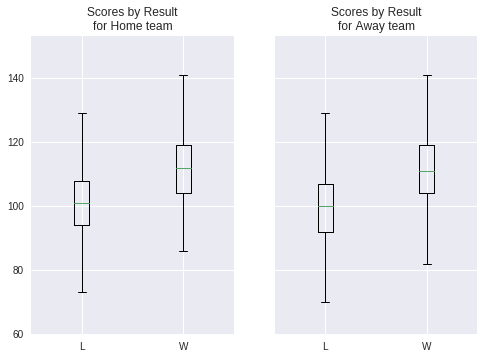

In [13]:
# Visualize the Outliers

myBS = pd.DataFrame(boxScoreAll.take(5000))

plotData = pd.DataFrame(myBS, columns = [13, 16]).rename(inplace=False, index = str, columns = {13:"teamRslt",16:'teamPTS'}).pivot(columns='teamRslt')

# Remove the NaN values from the array and make into a list because they will not be the same length
plotdata = np.array(plotData)
mask = ~np.isnan(plotdata)
plotdata = [d[m] for d, m in zip(plotdata.T, mask.T)]

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
axes[0].boxplot(plotdata, showfliers = True, labels=list('LW'))
axes[0].set_title("Scores by Result\nfor Home team")

# Repeat again for the away team
plotData = pd.DataFrame(myBS, columns = [69, 72]).rename(inplace=False, index = str, columns = {69:"teamRslt",72:'teamPTS'}).pivot(columns='teamRslt')
plotdata = np.array(plotData)
mask = ~np.isnan(plotdata)
plotdata = [d[m] for d, m in zip(plotdata.T, mask.T)]

axes[1].boxplot(plotdata, showfliers = True, labels=list('LW'))
axes[1].set_title("Scores by Result\nfor Away team")

fig.subplots_adjust(hspace=50)
plt.show()

In [1]:
# Compare Home Win/Loss record with scatterplot
boxScoreAll = boxScoreAll.withColumn('teamPTSDiff', abs(boxScoreAll['teamPTS'] - boxScoreAll['opptPTS']))

pdDataFrame = pd.DataFrame(boxScoreAll.toPandas())
#print(pdDataFrame)

plt.scatter(x = pdDataFrame.teamPTSDiff, y = pdDataFrame.teamPTS, c = pdDataFrame.teamRslt.map({'Win': 1, 'Loss': 0}), label = pdDataFrame.teamRslt)
plt.title('Points differential in Wins vs Losses')
plt.ylabel('Home Points')
plt.xlabel('Absolute Points Differential')
#plt.legend()
plt.show()

cdict = {'Loss': 'red', 'Win': 'green'}
fig, ax = plt.subplots()
for g in np.unique(pdDataFrame.teamRslt):
    ix = np.where(pdDataFrame.teamRslt == g)
    ax.scatter(pdDataFrame.teamPTSDiff[ix], pdDataFrame.teamPTS[ix]) #, c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

NameError: ignored

In [105]:
# ro.r('x=c()')
# ro.r('x[1] = 1 + 2')
# ro.r('x[3] = 1 + 77')
# x = pandas2ri.ri2py(r['x'])
# print(ro.r('x'))
# print(x)

grdevices = importr('grDevices')
grdevices.png(file='mapplot.png', width=1300, height=1000)


# Add the teamPTSDiff column
#boxScoreAll = boxScoreAll.withColumn('teamPTSDiff', abs(boxScoreAll['teamPTS'] - boxScoreAll['opptPTS']))
#boxScoreAll.show()

# Compare Home Win/Loss record with scatterplot
pandas2ri.activate()
pdDataFrame = pd.DataFrame(boxScoreAll.toPandas())
#plot_r_df = pandas2ri.py2ri(pdDataFrame)
#plot_r_df = ro.DataFrame(pdDataFrame)

ggplt = importr('ggplot2')
import rpy2.robjects.lib.ggplot2 as ggplot2

myPlt = ggplot2.ggplot(plot_r_df) + ggplot2.aes_string(x = 'teamPTSDiff', y = 'teamPTS')

myPlt.plot()

print(myPlt)

(ggplot2.ggplot(plot_r_df) + ggplot2.aes_string(x = 'teamPTSDiff', y = 'teamPTS')).plot()

grdevices.dev_off()



# myPlt = ggplot2.ggplot(plot_r_df)
# myPlt = (myPlt + ggplot2.aes_string(x = 'teamPTS', y = 'opptPTS'))
# plotpropC = ggplt.ggplot(plot_r_df)
# + ggplot2.aes(x = 'teamPTSDiff', y = 'teamPTS') # + geom_point(aes(color = teamRslt)) # + theme(panel.background = element_blank(), panel.border = element_rect(colour="black", fill=NA, size=1, linetype="solid"), legend.position = "bottom") + scale_x_continuous(name ="Absolute Points Differential") + scale_y_continuous(name ="Home Points") + ggtitle("Points differential Home vs Away")
# #print(plot_r_df)
# myPlt.plot()
# plotpropC.plot()
# #print(plotpropC)
# a = ro.r("dev.copy(png,'/tmp/out.png')")
# print(a)


2


In [94]:
# Remove the columns that are not known before the game starts by selecting the columns that do.
boxScoreAll = boxScoreAll.select('gmDate','gmTime','seasTyp','offLNm1','offFNm1','offLNm2','offFNm2','offLNm3','offFNm3','teamAbbr','teamConf','teamDiv','teamLoc','teamRslt','teamDayOff','opptAbbr','opptConf','opptDiv','opptLoc','opptDayOff','daysSince')
boxScoreAll.show(5)

+-------------------+------+-------+--------+-------+--------+-------+----------+-------+--------+--------+---------+-------+--------+----------+--------+--------+---------+-------+----------+---------+
|             gmDate|gmTime|seasTyp| offLNm1|offFNm1| offLNm2|offFNm2|   offLNm3|offFNm3|teamAbbr|teamConf|  teamDiv|teamLoc|teamRslt|teamDayOff|opptAbbr|opptConf|  opptDiv|opptLoc|opptDayOff|daysSince|
+-------------------+------+-------+--------+-------+--------+-------+----------+-------+--------+--------+---------+-------+--------+----------+--------+--------+---------+-------+----------+---------+
|2016-10-25 00:00:00| 08:00|Regular|    Lane|   Karl|   Adams| Bennie|   Kennedy|   Bill|     CLE|    East|  Central|   Home|     Win|         0|      NY|    East| Atlantic|   Away|         0|        0|
|2016-10-25 00:00:00| 10:00|Regular| Buchert|   Nick|Callahan|   Mike|     Brown|   Tony|     POR|    West|Northwest|   Home|     Win|         0|     UTA|    West|Northwest|   Away|       

In [95]:
# Fix the rows that have the wrong times - they need 12hr deducted from their times
boxScoreAll.filter('gmTime > "12:30"').select('gmtime').show()

boxScoreAll = boxScoreAll.withColumn("gmTime", when(boxScoreAll["gmTime"] > '12:30', boxScoreAll["gmTime"] - '12:00').otherwise(boxScoreAll["gmTime"]))

boxScoreAll.filter('gmTime > "12:30"').select('gmtime').show()

+------+
|gmtime|
+------+
| 18:00|
| 18:00|
| 19:00|
| 19:00|
+------+

+------+
|gmtime|
+------+
+------+



In [0]:
# Compare Home Win/Loss record with bar graph






# To do




######################################################################################################
### For the Standings preparation - the next set of steps are for the standings data preparation
######################################################################################################

In [51]:
# Join the two years datasets
standingsAll = standings1617.union(standings1718)
standingsAll.show(1)

# Rename the 'teamAbbr' column to prevent clash later
standingsAll = standingsAll.withColumnRenamed('teamAbbr', 'steamAbbr')
standingsAll.show(1)

print("Standings 1617:", standings1617.count())
print("Standings 1718:", standings1718.count()) 
# There are more standings rows in the 17/18 dataset because the season runs for a week longer
print("Standings All:", standingsAll.count())

+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+------------+---------+---------+-----------+--------+--------+
|             stDate|teamAbbr|rank|rankOrd|gameWon|gameLost|stk|stkType|stkTot|gameBack|ptsFor|ptsAgnst|homeWin|homeLoss|awayWin|awayLoss|confWin|confLoss|lastFive|lastTen|gamePlay|ptsScore|ptsAllow|ptsDiff|opptGmPlay|opptGmWon|opptOpptGmPlay|opptOpptGmWon|sos|relPercIndx|mov|srs|pwPerc|pythPerc1391|wpyth1391|lpyth1391|pythPerc165|wpyth165|lpyth165|
+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+--------

##################################################################################
### Merge the standings data into the box score data
##################################################################################

In [52]:
# Home team data
boxWithStand = boxScoreAll.join(standingsAll, (boxScoreAll.teamAbbr == standingsAll.steamAbbr) & (date_sub(boxScoreAll.gmDate, 1) == to_date(standingsAll.stDate)))
print(boxScoreAll.count())
print(boxWithStand.count())

2460
2460


In [53]:
# Away team data

# Rename columns by adding a suffix so that there are no name clashes
opptStandings = standingsAll.select(*(col(x).alias(x + '_oppt') for x in standingsAll.columns))

# Join the tables
boxWithStand = boxWithStand.join(opptStandings, (boxScoreAll.opptAbbr == opptStandings.steamAbbr_oppt) & (date_sub(boxScoreAll.gmDate, 1) == to_date(opptStandings.stDate_oppt)))
print(boxScoreAll.count())
print(boxWithStand.count())


2460
2460


In [0]:
# Compare Win/Loss record with rank






# To do




##################################################################################

Split the data and prepare for Machine Learning
##################################################################################

In [0]:
##############
# Training data - get all the rows that are pre 2018-01-01

In [55]:
trainingData = boxWithStand.filter('gmDate < "2018-01-01"')
trainingData.count()

1774

In [0]:
##############
# Test data - get all the rows that are between 2018-01-01 and 2018-02-07

In [57]:
testData = boxWithStand.filter('gmDate >= "2018-01-01" AND gmDate <= "2018-02-07"')
testData.count()

260

In [0]:
######################
# Feature Selection

In [0]:
#selector = ChiSqSelector(numTopFeatures=50, featuresCol="features", outputCol="selectedFeatures", labelCol="teamRslt")
#selector = ChiSqSelector(numTopFeatures=50, outputCol="selectedFeatures", labelCol="teamRslt")
selector = ChiSqSelector(numTopFeatures=50, labelCol="teamRslt", outputCol = "selectedFeatures")
chiData = trainingData.select('gmDate', 'gameBack', 'ptsAgnst', 'ptsFor', 'stkTot', 'ptsDiff', 'homeWin', 'awayWin')
result = selector.fit(trainingData).transform(trainingData)

#print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.show()

In [36]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

df = spark.createDataFrame([
    (7, Vectors.dense([0.0, 0.0, 18.0, 1.0]), 1.0,),
    (8, Vectors.dense([0.0, 1.0, 12.0, 0.0]), 0.0,),
    (9, Vectors.dense([1.0, 0.0, 15.0, 0.1]), 0.0,)], ["id", "features", "clicked"])

selector = ChiSqSelector(numTopFeatures=1, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="clicked")

result = selector.fit(df).transform(df)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.show()

ChiSqSelector output with top 1 features selected
+---+------------------+-------+----------------+
| id|          features|clicked|selectedFeatures|
+---+------------------+-------+----------------+
|  7|[0.0,0.0,18.0,1.0]|    1.0|          [18.0]|
|  8|[0.0,1.0,12.0,0.0]|    0.0|          [12.0]|
|  9|[1.0,0.0,15.0,0.1]|    0.0|          [15.0]|
+---+------------------+-------+----------------+



In [0]:
# Select the columns chosen by Feature Selection

In [0]:
# Assemble the column values into the vector format
assembler = VectorAssembler(inputCols=['jobVec','maritalVec','educationVec','defaultVec',
                                       'housingVec','loanVec','contactVec','poutcomeVec',
                                       'age', 'balance', 'duration', 'campaign', 'pdays',
                                       'previous'], outputCol="features")

In [62]:
# Split the Training data into 70 Training & 30 Validation
lr_train, lr_test = trainingData.randomSplit([0.7,0.3])

# Create instance of the logistic regression model.
final_model = LogisticRegression()

# Now fit the model on a subset of data.
fit_final = final_model.fit(lr_train)

# And evaluate it against the test data.
predictions_and_labels = fit_final.evaluate(lr_test)

predictions_and_labels.predictions.show()

IllegalArgumentException: ignored

In [0]:
# Use Binomial Regression 

lrModel = lr.fit(training)

# Instead of printing the coefficients/intercept, let's try to get a high level view of the model output. 
trainingSummary = lrModel.summary

# Print schema again. Note the additional columns. As with other models, we simply want to compare the label (actual value) to the predicted value.
trainingSummary.predictions.printSchema()

# Visualise the DataFrame. Visually compare label to prediction. What do you see? 
trainingSummary.predictions.show()